# Parkinson Speech Dataset with Multiple Types of Sound Recordings

##### L'objet du devoir est de mettre en pratique les différentes compétences, nécessaires au métier de data-scientist, vues en cours cette année.


## Packages

In [1]:
import selenium
from selenium import webdriver
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV

## Push sur Git 

In [263]:
!git add Projet_Python_DataAnalysis.ipynb
!git commit -m "fin"
!git push 


[master 414b606] Gradient Boosting
 1 file changed, 149 insertions(+), 61 deletions(-)
fatal: unable to access 'https://github.com/cjacques4/Parkinson-Speech-Dataset-with-Multiple-Types-of-Sound-Recordings.git/': Could not resolve host: github.com


# 1. Téléchargement de la base de données via WebScrapping

In [ ]:
driver = webdriver.Chrome(executable_path="./chromedriver")

url = "https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings#"
driver.get(url)

In [ ]:
# Télécharger le dataset
driver.find_element_by_link_text('Data Folder').click()
xpath = '/html/body/table/tbody/tr[4]/td[2]/a'
driver.find_element_by_xpath(xpath).click()

# 2. Data Visualisation (matplotlib)

## Importer la base de données

Les fichiers téléchargés étaient en .txt, nous avons alors utilisé la fonction read_csv afin de pouvoir les traiter comme des fichiers csv,et nous avons ajouter un header avec le nom de chaque colonnes : 

In [2]:
# Nous allons utilisé df comme base d'apprentissage 
# et nous utiliserons df_val comme jeu de validation final 

df = pd.read_csv ('train_data.txt', delimiter=",", header=0, index_col = [0], 
                        names=['id',
                               'Jitter_local','Jitter_local_absolute','Jitter_rap','Jitter_ppq5','Jitter_ddp',
                               'Shimmer_local','Shimmer_local_dB','Shimmer_apq3','Shimmer_apq5', 'Shimmer_apq11','Shimmer_dda', 
                               'AC','NTH','HTN', 
                               'Median_pitch','Mean_pitch','Standard_deviation','Minimum_pitch','Maximum_pitch',
                               'Number_of_pulses','Number_of_periods','Mean_period','Standard_deviation_of_period',
                               'Fraction_of_locally_unvoiced_frames','Number_of_voice_breaks','Degree_of_voice_breaks',
                               'UPDRS', 
                               'class_information']) 
df_val = pd.read_csv ('test_data.txt', delimiter=",", header=0, index_col = [0], 
                        names=['id',
                               'Jitter_local','Jitter_local_absolute','Jitter_rap','Jitter_ppq5','Jitter_ddp',
                               'Shimmer_local','Shimmer_local_dB','Shimmer_apq3','Shimmer_apq5', 'Shimmer_apq11','Shimmer_dda', 
                               'AC','NTH','HTN', 
                               'Median_pitch','Mean_pitch','Standard_deviation','Minimum_pitch','Maximum_pitch',
                               'Number_of_pulses','Number_of_periods','Mean_period','Standard_deviation_of_period',
                               'Fraction_of_locally_unvoiced_frames','Number_of_voice_breaks','Degree_of_voice_breaks', 
                               'class_information']) 

## Matplotlib

### Répartition de la cible à prédire : le score UPDRS

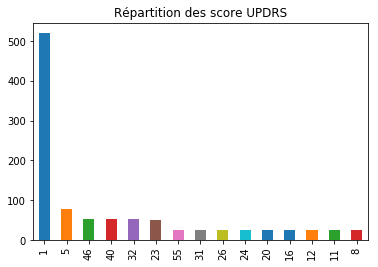

In [3]:
title = "Répartition des score UPDRS"
to_plot = df.UPDRS.value_counts(dropna=False)
to_plot.plot.bar(title=title)

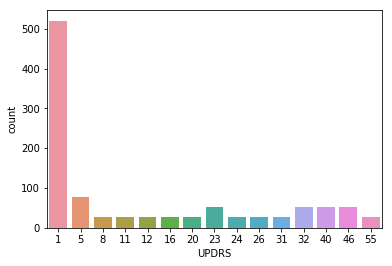

In [4]:
#Même principe avec un affichage différent

import seaborn as sns
sns.countplot(df['UPDRS'],label="Count")
plt.show()

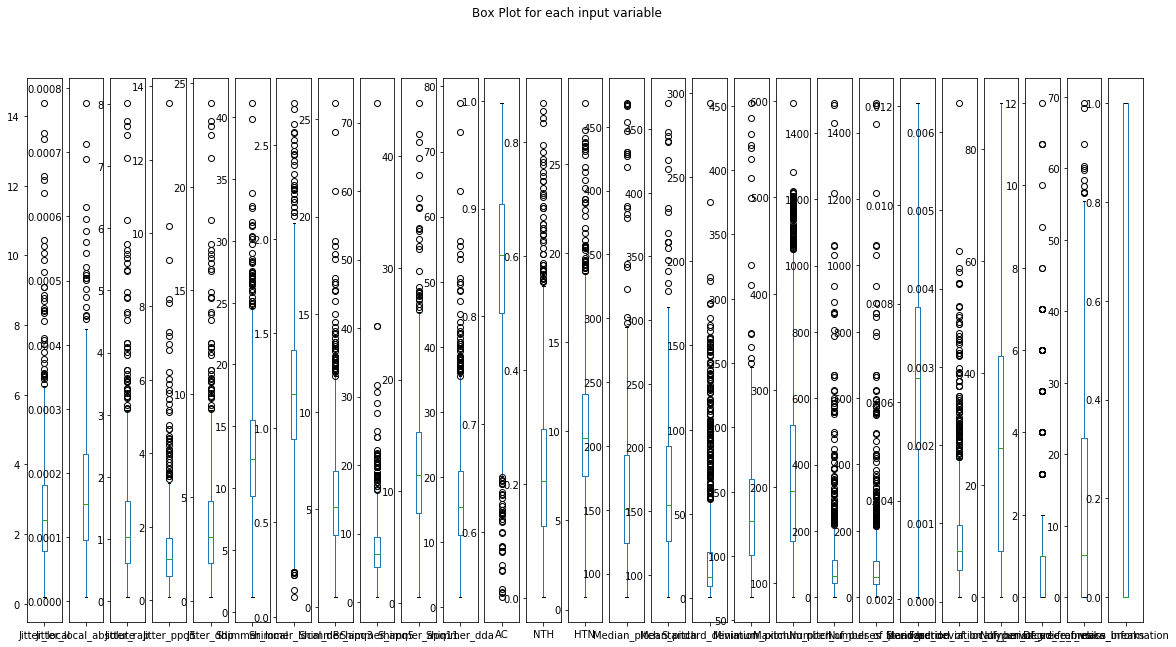

In [5]:
df.drop('UPDRS', axis=1).plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(20,10), 
                                        title='Box Plot for each input variable')
plt.show()

### Impact de certaines features sur le score UPDRS

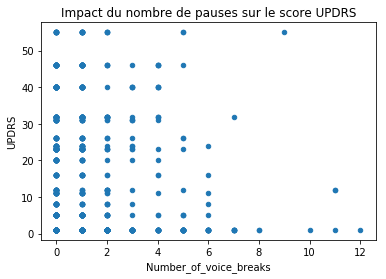

In [6]:
title = "Impact du nombre de pauses sur le score UPDRS"
df.plot.scatter("Number_of_voice_breaks", "UPDRS",title=title)

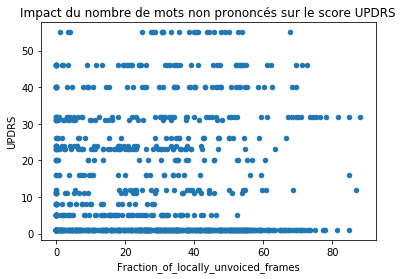

In [7]:
title = "Impact du nombre de mots non prononcés sur le score UPDRS"
df.plot.scatter("Fraction_of_locally_unvoiced_frames", "UPDRS",title=title)

# 3. Data Préparation (pandas)

##  Pré-traitement

In [9]:
df.head()

,Jitter_local,Jitter_local_absolute,Jitter_rap,Jitter_ppq5,Jitter_ddp,Shimmer_local,Shimmer_local_dB,Shimmer_apq3,Shimmer_apq5,Shimmer_apq11,...,Maximum_pitch,Number_of_pulses,Number_of_periods,Mean_period,Standard_deviation_of_period,Fraction_of_locally_unvoiced_frames,Number_of_voice_breaks,Degree_of_voice_breaks,UPDRS,class_information
id,,,,,,,,,,,,,,,,,,,,,
1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,7.194,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,7.548,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,16.779,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,12.823,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1
1,2.470,0.000126,1.358,1.341,4.075,10.696,1.256,5.262,7.076,9.199,...,202.812,74,73,0.005118,0.000187,23.214,0,0.000,23,1


In [10]:
df_val.head().T

id,1,1,1,1,1
Jitter_local,0.143000,0.162000,0.140000,0.150000,0.208000
Jitter_local_absolute,0.000007,0.000008,0.000007,0.000007,0.000009
Jitter_rap,0.073000,0.087000,0.075000,0.080000,0.077000
Jitter_ppq5,0.081000,0.089000,0.089000,0.097000,0.095000
Jitter_ddp,0.219000,0.260000,0.224000,0.240000,0.230000
Shimmer_local,1.236000,1.338000,1.086000,1.049000,1.241000
Shimmer_local_dB,0.107000,0.117000,0.094000,0.091000,0.109000
Shimmer_apq3,0.612000,0.630000,0.556000,0.533000,0.487000
Shimmer_apq5,0.904000,0.948000,0.747000,0.698000,0.715000
Shimmer_apq11,0.894000,1.017000,0.823000,0.777000,1.568000


In [11]:
#Nous avons 1039 values et 28 features dans le dataset:
df.shape

(1039, 28)

In [12]:
#Nous avons 167 values et 27 features dans le dataset de test:
df_val.shape

(167, 27)

In [13]:
#Nous avons que des valeurs numériques :
df.dtypes

Jitter_local                           float64
Jitter_local_absolute                  float64
Jitter_rap                             float64
Jitter_ppq5                            float64
Jitter_ddp                             float64
Shimmer_local                          float64
Shimmer_local_dB                       float64
Shimmer_apq3                           float64
Shimmer_apq5                           float64
Shimmer_apq11                          float64
Shimmer_dda                            float64
AC                                     float64
NTH                                    float64
HTN                                    float64
Median_pitch                           float64
Mean_pitch                             float64
Standard_deviation                     float64
Minimum_pitch                          float64
Maximum_pitch                          float64
Number_of_pulses                         int64
Number_of_periods                        int64
Mean_period  

## Visualisation des NA

Ici nous avons de la chance car notre base de données est très propre, elle ne contient aucune valeur nulle. 

In [14]:
#Check NA test
null_counts = df_val.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Jitter_local                           0
Jitter_local_absolute                  0
Jitter_rap                             0
Jitter_ppq5                            0
Jitter_ddp                             0
Shimmer_local                          0
Shimmer_local_dB                       0
Shimmer_apq3                           0
Shimmer_apq5                           0
Shimmer_apq11                          0
Shimmer_dda                            0
AC                                     0
NTH                                    0
HTN                                    0
Median_pitch                           0
Mean_pitch                             0
Standard_deviation                     0
Minimum_pitch                          0
Maximum_pitch                          0
Number_of_pulses                       0
Number_of_periods                      0
Mean_period                            0
Standard_deviation_of_period           0
Fraction_of_locally

In [15]:
#Check NA train
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Jitter_local                           0
Jitter_local_absolute                  0
Jitter_rap                             0
Jitter_ppq5                            0
Jitter_ddp                             0
Shimmer_local                          0
Shimmer_local_dB                       0
Shimmer_apq3                           0
Shimmer_apq5                           0
Shimmer_apq11                          0
Shimmer_dda                            0
AC                                     0
NTH                                    0
HTN                                    0
Median_pitch                           0
Mean_pitch                             0
Standard_deviation                     0
Minimum_pitch                          0
Maximum_pitch                          0
Number_of_pulses                       0
Number_of_periods                      0
Mean_period                            0
Standard_deviation_of_period           0
Fraction_of_locally

# 4. Modélisation (scikit learn)

Nous allons séparer notre dataset en une valeur target avec la cible à prédire et X toutes nos features : 

In [3]:
#Read Data 
target = df.UPDRS
df.drop(['UPDRS'], axis='columns', inplace=True)
X = df

## Séparer le jeu de données en train et test avec une cross validation

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.33)

/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Standardiser les valeurs

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)                 
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

## Choix d'un algorithme d'apprentissage

### Support Vector Machine (SVM)

Dans un premier temps, nous allons lancer un svm avec les paramètres par défaut puis nous allons aller au-delà de ces paramètres à l’aide d’un Grid Search :

In [6]:
from sklearn import svm
algorithme = svm.SVC()
algorithme.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [7]:
from sklearn import cross_validation
cross_validation.cross_val_score(algorithme, X, target, n_jobs=-1)

array([0.49431818, 0.49712644, 0.51032448])

### Aller au delà des paramètres par défaut :

In [8]:
from sklearn import grid_search
parameters = {  'gamma' : [0.1,0.01, 0.001, 0.0001],
                'C'      : [100,1000, 10000],
                "probability" : [True],
                'kernel' : ['rbf', 'poly', 'sigmoid','linear'],
                "degree" : [1,3,5]}

grid_svm       = grid_search.GridSearchCV(algorithme, parameters, n_jobs=-1)

grid_svm.fit(X_train, y_train)

print (grid_svm.best_score_, grid_svm.best_estimator_)

/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.7528735632183908 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [9]:
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(grid_svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(grid_svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.97
Accuracy of SVM classifier on test set: 0.71


### Quelques algo avec les paramètres par défaut :

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.76
Accuracy of Logistic regression classifier on test set: 0.69


## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.71


## K-Nearest Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.79
Accuracy of K-NN classifier on test set: 0.68


## Aller au delà des hyper paramètres

### Gradient Boosting 

In [10]:
from sklearn.ensemble import GradientBoostingClassifier


algorithme3 = GradientBoostingClassifier()
algorithme3.get_params()


parameters = {'n_estimators': [10,100,200]                 ,
                  'max_depth': None                        ,
                  'min_samples_split': [2,7,3]             ,
                  'learning_rate': [0.01,0.1, 0,2]              ,
                  'loss': 'ls'                             }



grid_gb     = grid_search.GridSearchCV(algorithme3, {})

grid_gb.fit(X_train, y_train)

print (grid_gb.best_score_, grid_gb.best_estimator_)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.7155172413793104 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [15]:
print('Accuracy of Gradient Boosting on training set: {:.2f}'
     .format(grid_gb.score(X_train, y_train)))
print('Accuracy of Gradient Boosting on test set: {:.2f}'
     .format(grid_gb.score(X_test, y_test)))

Accuracy of Gradient Boosting on training set: 1.00
Accuracy of Gradient Boosting on test set: 0.73


### Random Forest

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

algorithme2 = RandomForestClassifier() 


parameters = {  "n_estimators"         : [ 10, 100, 1000 ], 
                "min_samples_leaf"     : [  3,   1,   7 ],
                "criterion"            : ["gini", "entropy"] }

grid_rf       = grid_search.GridSearchCV(algorithme2, parameters, n_jobs=-1)

grid_rf.fit(X_train, y_train)

print (grid_rf.best_score_, grid_rf.best_estimator_)

0.7772988505747126 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [14]:
print('Accuracy of Random Forest on training set: {:.2f}'
     .format(grid_rf.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'
     .format(grid_rf.score(X_test, y_test)))

Accuracy of Random Forest on training set: 1.00
Accuracy of Random Forest on test set: 0.75


# 5. Visualisation des performances

# Tester tous les algos

In [29]:
def get_sklearn_algorithms(verbose = False):
    """
    Explore all submodule of sklearn and fetch functions having a 'fit' attribute.
    
    Be careful : some functions are not models (ex : crossvalidators)
    Parameters :
        debug = print or not stuff on console
    Return :
        dict : { module : [ fit_functions] }
    """
    from collections import defaultdict
    import importlib
    import sklearn
    algos = defaultdict(list)
    if verbose : print (dir(sklearn))
    for nom_module in sklearn.__dict__['__all__']:    
        if verbose : print (nom_module)
        try:
            to_import = "sklearn.%s"%nom_module
            module    = importlib.import_module(to_import)
            for nom_fonction in dir(module):
                fonction = getattr(module, nom_fonction)
                if hasattr(fonction, "fit"):
                    if verbose : print (" nom algorithme  = ", nom_fonction)
                    algos[nom_module].append(fonction)                                            
        except Exception as e:
            if verbose : print (e)
        if verbose: print ("="*30)
    return algos

In [30]:
algos = get_sklearn_algorithms(True)
for key in algos.keys():
    print ("\n===>",key)
    algos_ = []
    for algo in algos[key]:
        classe_algo = str(algo)
        nom_algo    = classe_algo[str(classe_algo).rfind(".")+1:str(classe_algo).rfind("'")]
        algos_.append(nom_algo)
    print (",".join(algos_))

['_ASSUME_FINITE', '__SKLEARN_SETUP__', '__all__', '__builtins__', '__cached__', '__check_build', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_contextmanager', 'base', 'clone', 'config_context', 'cross_validation', 'ensemble', 'exceptions', 'externals', 'feature_selection', 'gaussian_process', 'get_config', 'grid_search', 'linear_model', 'logger', 'logging', 'metrics', 'model_selection', 'multiclass', 'neighbors', 'os', 'preprocessing', 'random_projection', 're', 'set_config', 'setup_module', 'svm', 'sys', 'tree', 'utils', 'warnings']
calibration
 nom algorithme  =  CalibratedClassifierCV
 nom algorithme  =  IsotonicRegression
 nom algorithme  =  LabelBinarizer
 nom algorithme  =  LabelEncoder
 nom algorithme  =  LinearSVC
 nom algorithme  =  _CalibratedClassifier
 nom algorithme  =  _SigmoidCalibration
cluster
 nom algorithme  =  AffinityPropagation
 nom algorithme  =  AgglomerativeClustering
 nom algorithme  =  Birch
 nom al

C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


 nom algorithme  =  BayesianGaussianMixture
 nom algorithme  =  DPGMM
 nom algorithme  =  GMM
 nom algorithme  =  GaussianMixture
 nom algorithme  =  VBGMM
model_selection
 nom algorithme  =  GridSearchCV
 nom algorithme  =  RandomizedSearchCV
multiclass
 nom algorithme  =  LabelBinarizer
 nom algorithme  =  OneVsOneClassifier
 nom algorithme  =  OneVsRestClassifier
 nom algorithme  =  OutputCodeClassifier
 nom algorithme  =  _ConstantPredictor
multioutput
 nom algorithme  =  ClassifierChain
 nom algorithme  =  MultiOutputClassifier
 nom algorithme  =  MultiOutputEstimator
 nom algorithme  =  MultiOutputRegressor
naive_bayes
 nom algorithme  =  BaseDiscreteNB
 nom algorithme  =  BernoulliNB
 nom algorithme  =  GaussianNB
 nom algorithme  =  LabelBinarizer
 nom algorithme  =  MultinomialNB
neighbors
 nom algorithme  =  KNeighborsClassifier
 nom algorithme  =  KNeighborsRegressor
 nom algorithme  =  KernelDensity
 nom algorithme  =  LSHForest
 nom algorithme  =  LocalOutlierFactor
 nom a

In [31]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [32]:
performances               = {}
modeles_a_tester           = []
classes_de_models_a_tester = algos.keys()
best_algorithm = 0
best_perf = 0
for classe_de_models in classes_de_models_a_tester:
    modeles_a_tester.extend(algos[classe_de_models])
    
for pointeur_vers_algo in modeles_a_tester:
    try:
        algorithme = pointeur_vers_algo()
        doc        = algorithme.__doc__
        name       = doc[:min(doc.find(":"), 25)].strip()
        print (name)
        algorithme.fit(X_train, y_train)
        performance = algorithme.score(X_test, y_test)
        print (performance)
        if performance >  best_perf:
            best_algorithm = algorithme
            best_perf = performance
            
        if 0<performance and performance<1:
            performances[name] = [performance]
    except Exception as e:
        if "label" in str(e): print ("Algo de classification")
        else                : print (str(e)[:50])
    print("="*30)

Probability calibration w
0.6880466472303207
Isotonic regression model
X should be a 1d array
Binarize labels in a one-
fit() takes 2 positional arguments but 3 were give
Encode labels with value
fit() takes 2 positional arguments but 3 were give
Linear Support Vector Cla
0.717201166180758
__init__() missing 1 required positional argument:
Sigmoid regression model.
bad input shape (696, 27)
Perform Affinity Propagat
'AffinityPropagation' object has no attribute 'sco
Agglomerative Cluste
'AgglomerativeClustering' object has no attribute 
Implements the Birch clus
'Birch' object has no attribute 'score'
Perform DBSCAN clustering
'DBSCAN' object has no attribute 'score'
Agglomerate features.
'FeatureAgglomeration' object has no attribute 'sc
K-Means clustering

    R
-4627.01314215459
Mean shift clustering usi
'MeanShift' object has no attribute 'score'
Mini-Batch K-Means cluste
-4775.207886894771
Spectral biclustering (Kl
'SpectralBiclustering' object has no attribute 'sc
Apply clusterin

C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 1.004e-01
  ConvergenceWarning)


-16.657056211158768
Sparse inverse covariance
-26.016099922691083
LedoitWolf Estimator
-17.715840784994153
Minimum Covariance Determ
-208.42941206297746
Oracle Approximating Shri
-16.67346762667254
Covariance estimator with
-21.696747864950325
CCA Canonical Correlation
0.0014220065608843147
PLSCanonical implements
-0.4652333127693111
PLS regression

    PLSRe
0.5261404438806938
Partial Least Square SVD
'PLSSVD' object has no attribute 'score'
Dictionary learning


C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


'DictionaryLearning' object has no attribute 'scor
Factor Analysis (FA)
-25.67261978574811
FastICA
'FastICA' object has no attribute 'score'
Incremental principal com
'IncrementalPCA' object has no attribute 'score'
Kernel Principal componen
'KernelPCA' object has no attribute 'score'
Latent Dirichlet Allocati
Negative values in data passed to LatentDirichletA
Mini-batch dictionary lea
'MiniBatchDictionaryLearning' object has no attrib
Mini-batch Sparse Princip
'MiniBatchSparsePCA' object has no attribute 'scor
Non-Negative Matrix Facto
Negative values in data passed to NMF (input X)
Principal component analy
-3.074379119560361
Principal component analy
'RandomizedPCA' object has no attribute 'score'
__init__() missing 1 required positional argument:
Sparse Principal Componen
'SparsePCA' object has no attribute 'score'
Dimensionality reduction
'TruncatedSVD' object has no attribute 'score'
DummyClassifier is a
0.26239067055393583
DummyRegressor is a
-0.00022279454766604978
An AdaBoost 

C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.5999908056980773
Lasso model fit with Leas
-0.00022279454766604978
Cross-validated Lasso, us
0.5976191926523886
Lasso model fit with Lars
0.6000523439365798
Ordinary least squar
0.6049126719273822
Logistic Regression (aka
0.6938775510204082
Logistic Regression CV (a
0.6676384839650146
Multi-task ElasticNet mod
For mono-task outputs, use ElasticNet
Multi-task L1/L2 ElasticN
For mono-task outputs, use ElasticNetCV
Multi-task Lasso model tr
For mono-task outputs, use ElasticNet
Multi-task L1/L2 Lasso wi
For mono-task outputs, use LassoCV
Orthogonal Matching Pursu
0.5974566049373755
Cross-validated Orthogona
0.5974566049373755
Passive Aggressive Classi
0.5801749271137027
Passive Aggressive Regres
0.22193838716586345
Perceptron

    Read more
0.597667638483965
RANSAC (RANdom SAmple Con


C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\

RANSAC could not find a valid consensus set. All `
Randomized Lasso.

    Ra
'RandomizedLasso' object has no attribute 'score'
Randomized Logistic Regre
'RandomizedLogisticRegression' object has no attri
Linear least squares with
0.6030524608587728
Ridge regression with bui
0.6064321022763259
Classifier using Ridge re
0.6443148688046647
Ridge classifier with bui
0.6443148688046647
Linear classifiers (SVM,
0.6326530612244898
Linear model fitted by mi
0.6090948872894117
Theil-Sen Estimator


C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.5371644089863974
Isomap Embedding

    Non
'Isomap' object has no attribute 'score'
Locally Linear Embedding
'LocallyLinearEmbedding' object has no attribute '
Multidimensional scaling
'MDS' object has no attribute 'score'
Spectral embedding for no
'SpectralEmbedding' object has no attribute 'score
t-distributed Stochastic
'TSNE' object has no attribute 'score'
Variational Bayesian esti
-6.7947675784645885
Dirichlet Process Gaussia
[ -50.61941347  -47.91401053  -57.58463642  -44.87343918  -46.64519449
  -51.36797283  -52.46163571  -48.33398333  -47.91838073  -56.55675167
  -47.97983798  -69.71251001  -48.74220815  -46.11900217  -45.93294037
  -46.61048191  -49.19413304  -63.20201426  -46.00426483  -50.23181812
  -45.93299704  -50.75774481  -45.90066564  -47.61497278  -58.14144686
  -50.61267523  -69.47242648  -46.4908911   -45.32344636  -47.80047333
  -50.85934242  -47.00801282 -127.64058154  -46.06939078  -47.87628107
  -48.3768253   -46.29693002  -47.74458694  -46.59198448  -45.274

-11078.467547383565
Performs approximate near
'LSHForest' object has no attribute 'score'
Unsupervised Outlier Dete
'LocalOutlierFactor' object has no attribute 'scor
Nearest centroid classifi
0.3469387755102041
Unsupervised learner for
'NearestNeighbors' object has no attribute 'score'
Classifier implementing a
Algo de classification
Regression based on neigh


C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (27 < 32).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (27 < 32).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (27 < 32).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning: The number of components

Input contains NaN, infinity or a value too large 
Bernoulli Restricted Bolt
'BernoulliRBM' object has no attribute 'score'
Multi-layer Perceptron cl


C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7580174927113703
Multi-layer Perceptron re


C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


0.6148075557363661
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
Binarize data (set featur
'Binarizer' object has no attribute 'score'
Constructs a transformer
'FunctionTransformer' object has no attribute 'sco
Imputation transformer fo
'Imputer' object has no attribute 'score'
Center a kernel matrix
'KernelCenterer' object has no attribute 'score'
Binarize labels in a one-
fit() takes 2 positional arguments but 3 were give
Encode labels with value
fit() takes 2 positional arguments but 3 were give
Scale each feature by its
'MaxAbsScaler' object has no attribute 'score'
Transforms features by sc
'MinMaxScaler' object has no attribute 'score'
Transform between iterabl
fit() takes 2 positional arguments but 3 were give
Normalize samples individ
'Normalizer' object has no attribute 'score'
Encode categorical intege
X needs to contain only non-negative integers.
Generate polynomial and i
'PolynomialFeatures' object has no attribute 's

C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Clement\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Clement\Anaconda3\lib

In [33]:
best_algorithm

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [34]:
performances

{'Probability calibration w': [0.6880466472303207],
 'Linear Support Vector Cla': [0.7201166180758017],
 'An object for detecting o': [0.4227405247813411],
 'CCA Canonical Correlation': [0.0014220065608843147],
 'PLS regression\n\n    PLSRe': [0.5261404438806938],
 'DummyClassifier is a': [0.26239067055393583],
 'An AdaBoost classifier.': [0.577259475218659],
 'An AdaBoost regressor.': [0.5982985966823817],
 'A Bagging classifier.': [0.7434402332361516],
 'A Bagging regressor.': [0.5916184283869692],
 'An extra-trees classifier': [0.7434402332361516],
 'An extra-trees regressor.': [0.5645447762247136],
 'Gradient Boosting for cla': [0.7405247813411079],
 'Gradient Boosting for reg': [0.6371279203233935],
 'A random forest classifie': [0.7259475218658892],
 'A random forest regressor': [0.6393319727363169],
 'The legacy Gaussian Proce': [0.40048902153510235],
 'Gaussian process classifi': [0.6938775510204082],
 'Gaussian process regressi': [0.06334871553985066],
 'Bayesian ARD regressio

In [35]:
import pandas as pd
df_performances = pd.DataFrame(performances).T

col_name = "performance"
df_performances.columns = [col_name]

df_performances = df_performances.sort_values(col_name)

In [36]:
df_performances

,performance
CCA Canonical Correlation,0.001422
Gaussian process regressi,0.063349
Passive Aggressive Regres,0.221938
A decision tree regressor,0.242964
DummyClassifier is a,0.262391
An extremely randomized t,0.265177
Nu Support Vector Regress,0.326120
Epsilon-Support Vector Re,0.345106
Nearest centroid classifi,0.346939
The legacy Gaussian Proce,0.400489


In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

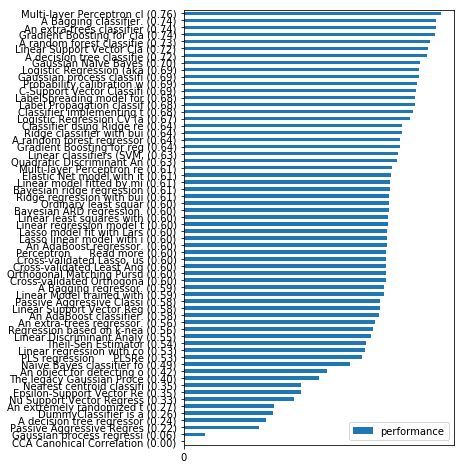

In [38]:
new_labels = []
for i, index in enumerate(df_performances.index):
    new_label = "%s (%.2f)"%(index,df_performances.performance[i])
    new_labels.append(new_label.replace("\n", " "))
    
fig , axes = plt.subplots(1,1)
df_performances.index = new_labels
fig.set_size_inches(15,8)
fig.subplots_adjust(left=0.65)
df_performances.sort_values(col_name).plot(kind='barh', ax=axes)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

pass

In [44]:
from sklearn import model_selection

seed = 7
models = []
models.append(('SVM', grid_svm))
models.append(('RF', grid_rf))
models.append(('GB', grid_gb))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

SVM: 0.714202 (0.102505)
RF: 0.719916 (0.071637)
GB: 0.702605 (0.089287)


[Text(0,0,'SVM'), Text(0,0,'RF'), Text(0,0,'GB')]

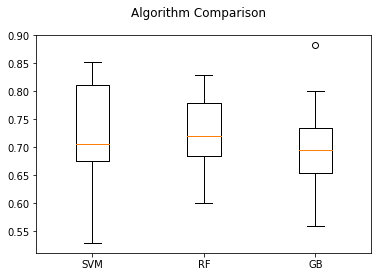

In [45]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

In [49]:
from numpy import mean
print(mean(results[-1]))


0.7026050420168067


On constate que parmis les trois algorithmes on obtient le meilleur résultat sur le dataset de test avec un AUC de 0.702